# A/B testing with Ratio Metrics

This notebook provides showcases how one can account for ratio OECs when conducting A/B testing. It also showcases that p-values obtained from linearisation are consistent with p-values obtained via much more computationally intensive bootstrap.

In [27]:
#Initial setup
import sys, os

root_path = os.path.realpath('..')
sys.path.insert(0, root_path)

from tw_experimentation.utils import ExperimentDataset

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We shall now generate a synthetic dataset with clicks and views columns at session level.

In [43]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

# Number of users and sessions
num_users = 1000
sessions_per_user = np.random.poisson(lam=5, size=num_users)

# Generate user ids
user_ids = np.arange(1, num_users + 1)

# Generate variant assignment (0 for control, 1 for treatment)
variants = np.random.choice([0, 1], size=num_users, p=[0.5, 0.5])

# Create the dataset
data = {
    'user_id': [],
    'variant': [],
    'session_id': [],
    'clicks': [],
    'views': []
}

session_id = 0

for user_id, variant, num_sessions in zip(user_ids, variants, sessions_per_user):
    # Generate correlated clicks and views for each user
    views = np.random.poisson(lam=10, size=num_sessions)
    if variant == 0:
        clicks = views * np.random.uniform(0.3, 0.5, size=num_sessions) + np.random.normal(0, 1, size=num_sessions)
    else:
        clicks = views * np.random.uniform(0.6, 0.8, size=num_sessions) + np.random.normal(0, 1, size=num_sessions)
    clicks = np.maximum(0, clicks)  # Ensure clicks are non-negative

    for session in range(num_sessions):
        session_id += 1
        data['user_id'].append(user_id)
        data['variant'].append(variant)
        data['session_id'].append(session_id)
        data['clicks'].append(int(clicks[session]))
        data['views'].append(int(views[session]))

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the dataframe
df.head()

,user_id,variant,session_id,clicks,views
0,1,0,1,2,8
1,1,0,2,1,10
2,1,0,3,1,7
3,1,0,4,4,11
4,1,0,5,7,15


In [44]:
#Aggregate to a user-level dataset
df = df.groupby(['user_id']).agg({'clicks': 'sum', 'views': 'sum', 'variant': 'first'}).reset_index()

To specify a linearised OEC one simply needs to provide an additional argument when defining an instance of ExperimentDataset. The key of the ratio_targets dictionary is the name of the OEC whereas the tuple specifies the columns used for construction (numerator, denominator).

In [30]:
experiment = ExperimentDataset(
    data=df,
    variant='variant',
    ratio_targets={'ctr': ('clicks', 'views')}
)

In [31]:
experiment.preprocess_dataset()
experiment.data.head()

,user_id,clicks,views,variant,ctr
0,1,15,51,0,-3.009901
1,2,25,34,1,12.993399
2,3,27,40,1,12.874587
3,4,46,59,1,25.165017
4,5,25,41,1,10.521452


In [32]:
#The new linearised column can be treated as a new continuous column and can even be improved by sensitivity-improving techniques.
experiment.metric_types

{'ctr': 'continuous'}

Below we shall generate a 1000 synthetic A/A tests and compare the p-values and t-statistics obtained from linearisation with those obtained from a naive transformation.

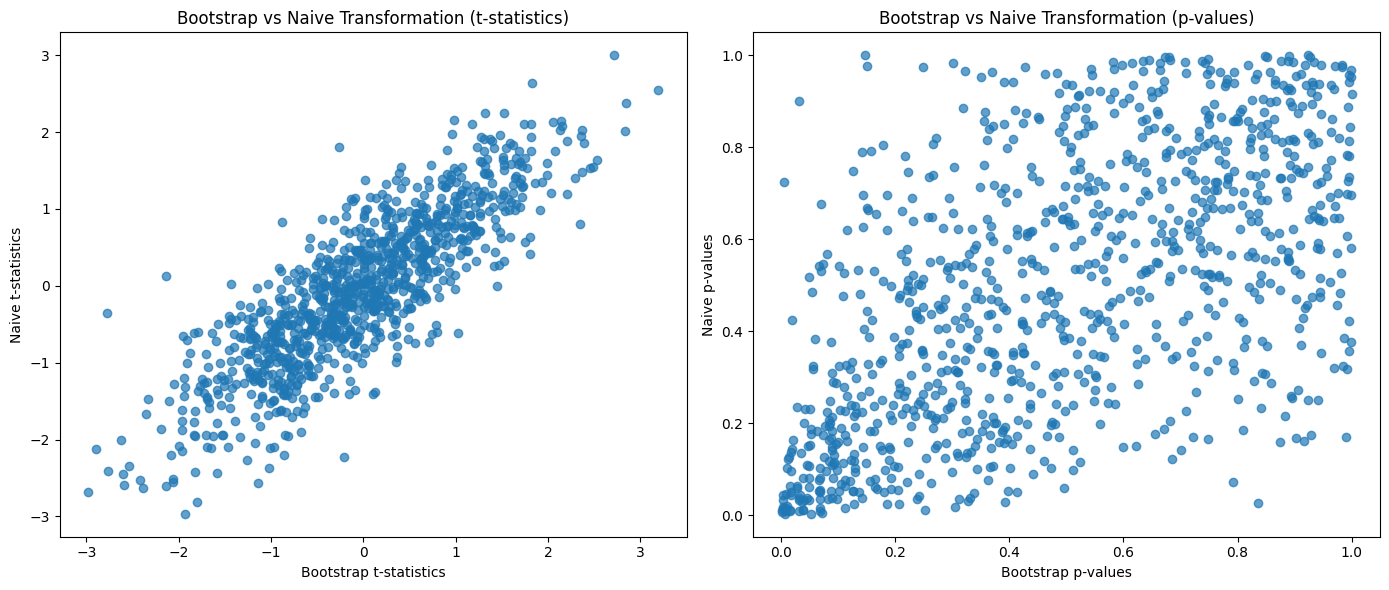

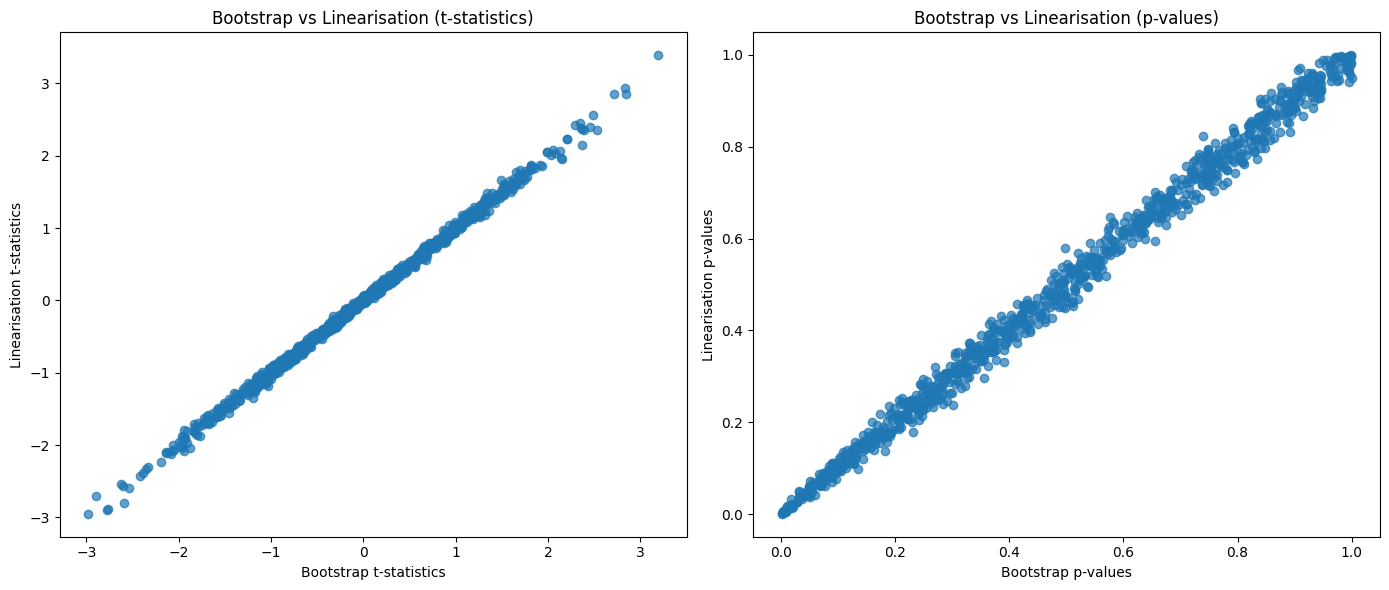

In [33]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Function to generate the dataset
def generate_dataset():
    num_users = 1000
    sessions_per_user = np.random.poisson(lam=5, size=num_users)
    user_ids = np.arange(1, num_users + 1)
    variants = np.random.choice([0, 1], size=num_users, p=[0.5, 0.5])
    
    data = {
        'user_id': [],
        'variant': [],
        'session_id': [],
        'clicks': [],
        'views': []
    }

    session_id = 0
    for user_id, variant, num_sessions in zip(user_ids, variants, sessions_per_user):
        views = np.random.poisson(lam=10, size=num_sessions)
        if variant == 0:
            clicks = views * np.random.uniform(0.3, 0.5, size=num_sessions) + np.random.normal(0, 1, size=num_sessions)
        else:
            clicks = views * np.random.uniform(0.3, 0.5, size=num_sessions) + np.random.normal(0, 1, size=num_sessions)
        clicks = np.maximum(0, clicks)  # Ensure clicks are non-negative

        for session in range(num_sessions):
            session_id += 1
            data['user_id'].append(user_id)
            data['variant'].append(variant)
            data['session_id'].append(session_id)
            data['clicks'].append(int(clicks[session]))
            data['views'].append(int(views[session]))

    df = pd.DataFrame(data)
    return df

# Function to perform bootstrap t-test
def bootstrap_ttest(df, n_bootstrap=1000):
    control = df[df['variant'] == 0]
    treatment = df[df['variant'] == 1]
    
    diffs = []
    for _ in range(n_bootstrap):
        control_sample = control.sample(frac=1, replace=True)
        treatment_sample = treatment.sample(frac=1, replace=True)
        
        control_ctr = control_sample['clicks'].sum() / control_sample['views'].sum()
        treatment_ctr = treatment_sample['clicks'].sum() / treatment_sample['views'].sum()
        
        diffs.append(treatment_ctr - control_ctr)
    
    t_stat = np.mean(diffs) / np.std(diffs)
    p_val = 2 * (1 - stats.norm.cdf(np.abs(t_stat)))
    return t_stat, p_val

# Function to perform naive transformation t-test
def naive_ttest(df):
    df_agg = df.groupby(['user_id', 'variant']).agg({'clicks': 'sum', 'views': 'sum'}).reset_index()
    df_agg['ctr'] = df_agg['clicks'] / df_agg['views']
    
    control = df_agg[df_agg['variant'] == 0]['ctr']
    treatment = df_agg[df_agg['variant'] == 1]['ctr']
    
    t_stat, p_val = stats.ttest_ind(treatment, control, equal_var=False)
    return t_stat, p_val

# Function to perform linearisation t-test
def linearisation_ttest(df):
    control = df[df['variant'] == 0]
    treatment = df[df['variant'] == 1]
    
    kappa = control['clicks'].sum() / control['views'].sum()
    df['linearised_oec'] = df['clicks'] - kappa * df['views']
    
    df_agg = df.groupby(['user_id', 'variant']).agg({'linearised_oec': 'sum'}).reset_index()
    
    control = df_agg[df_agg['variant'] == 0]['linearised_oec']
    treatment = df_agg[df_agg['variant'] == 1]['linearised_oec']
    
    t_stat, p_val = stats.ttest_ind(treatment, control, equal_var=False)
    return t_stat, p_val

# Initialize lists to store results
bootstrap_results = []
naive_results = []
linearisation_results = []

# Generate 100 datasets and compute t-test results
for _ in range(1000):
    df = generate_dataset()
    
    t_stat_bootstrap, p_val_bootstrap = bootstrap_ttest(df)
    bootstrap_results.append((t_stat_bootstrap, p_val_bootstrap))
    
    t_stat_naive, p_val_naive = naive_ttest(df)
    naive_results.append((t_stat_naive, p_val_naive))
    
    t_stat_linearisation, p_val_linearisation = linearisation_ttest(df)
    linearisation_results.append((t_stat_linearisation, p_val_linearisation))

# Convert results to DataFrame for easy plotting
results_df = pd.DataFrame({
    'bootstrap_t_stat': [res[0] for res in bootstrap_results],
    'bootstrap_p_val': [res[1] for res in bootstrap_results],
    'naive_t_stat': [res[0] for res in naive_results],
    'naive_p_val': [res[1] for res in naive_results],
    'linearisation_t_stat': [res[0] for res in linearisation_results],
    'linearisation_p_val': [res[1] for res in linearisation_results]
})

# Scatter plot for bootstrap vs naive transformation
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(results_df['bootstrap_t_stat'], results_df['naive_t_stat'], alpha=0.7)
plt.xlabel('Bootstrap t-statistics')
plt.ylabel('Naive t-statistics')
plt.title('Bootstrap vs Naive Transformation (t-statistics)')

plt.subplot(1, 2, 2)
plt.scatter(results_df['bootstrap_p_val'], results_df['naive_p_val'], alpha=0.7)
plt.xlabel('Bootstrap p-values')
plt.ylabel('Naive p-values')
plt.title('Bootstrap vs Naive Transformation (p-values)')

plt.tight_layout()
plt.show()

# Scatter plot for bootstrap vs linearisation
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(results_df['bootstrap_t_stat'], results_df['linearisation_t_stat'], alpha=0.7)
plt.xlabel('Bootstrap t-statistics')
plt.ylabel('Linearisation t-statistics')
plt.title('Bootstrap vs Linearisation (t-statistics)')

plt.subplot(1, 2, 2)
plt.scatter(results_df['bootstrap_p_val'], results_df['linearisation_p_val'], alpha=0.7)
plt.xlabel('Bootstrap p-values')
plt.ylabel('Linearisation p-values')
plt.title('Bootstrap vs Linearisation (p-values)')

plt.tight_layout()
plt.show()
